In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
from IPython.display import Image, display
from scipy.optimize import minimize

file_etfs =  'ETFs.csv'

# Three Asset Example (With No Correlation)

,Bond,Equity
Bond,1.00,-0.11
Equity,-0.11,1.00


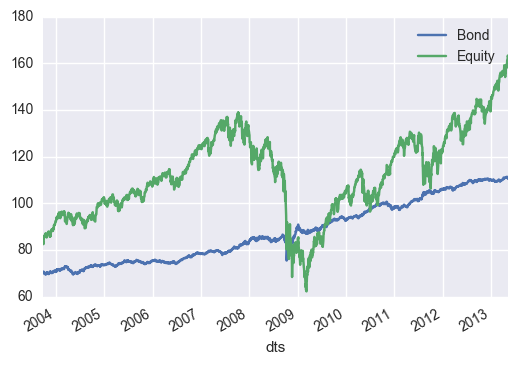

In [2]:
cols = ["dts","AGG","GLD","SPY"]
cols = ["dts","AGG","SPY"]
df = pd.read_csv(file_etfs,usecols= cols, index_col='dts').rename(columns={"AGG":"Bond","GLD":"Commodity","SPY":"Equity"})
df.set_index(pd.to_datetime(df.index,format="%Y%m%d"),inplace=True)
df = df.dropna(0)
pt_ret = df.pct_change()
df.plot(figsize=(6,4))
np.round(pt_ret.corr(),2)


# Simple Risk Parity

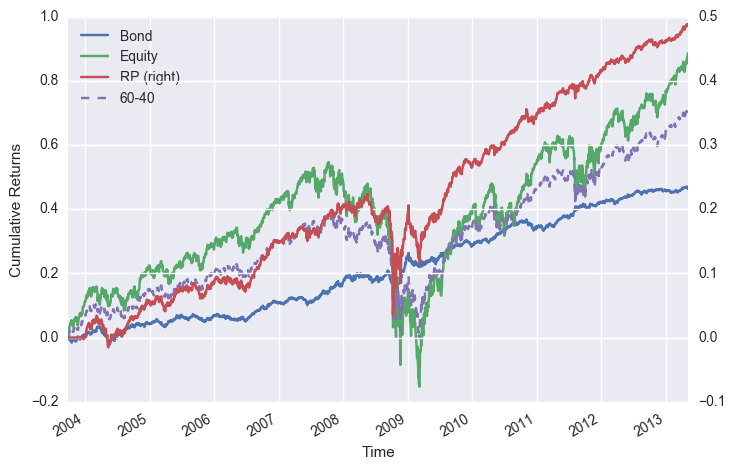

In [3]:
# Simple risk parity treats if there is no correlation among assets, thus 
# the weight is inversely proportional to recent asset volatility
# halflife used to compute asset volatility

#df_ret = pt_ret.head().unstack().reset_index().rename(columns={"level_0":"asset_id",0:"ret"})

df_std = pt_ret.rolling(window =60).std()*np.sqrt(252)
wts = (1/df_std).apply(lambda x: x/((1/df_std).sum(axis=1)))
df_ret_rp = (pt_ret * wts.shift(1)).sum(axis=1)
df_ret_static = pt_ret.dot(np.array([0.4, 0.6]))

ax = pt_ret.cumsum().plot()
df_ret_rp.cumsum().to_frame("RP").plot(ax =ax, secondary_y= True)
(df_ret_static).to_frame("60-40").cumsum().plot(ax=ax, style=['--'])

ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")

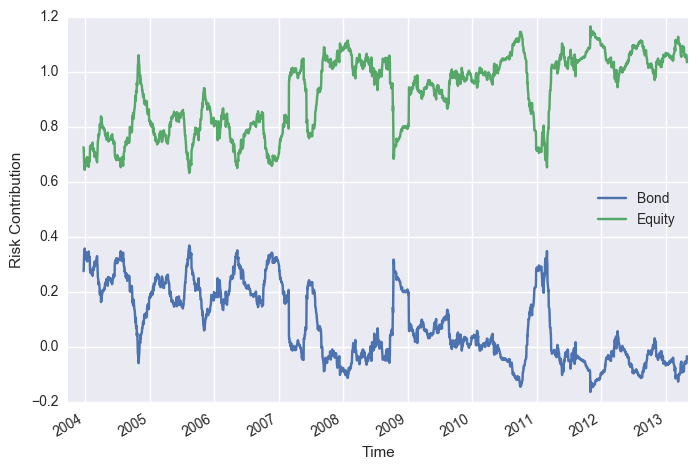

In [4]:
pt_risk_contribution = wts * 0
weighting_scheme = "NRP"
weighting_scheme = "60-40"
lookback = 60
for i in np.arange(len(wts)):
    if i >= lookback:
        if weighting_scheme == "NRP":
            wts_vec = wts.iloc[i]
        elif weighting_scheme == "60-40":
            wts_vec = np.array([0.6,0.4])
            
        Sigma = pt_ret.iloc[i-lookback+1:i,:].cov()
        var_p = wts_vec.dot(Sigma).dot(wts_vec)
        risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
        pt_risk_contribution.iloc[i,:] = np.array(risk_contribution_vec)

ax = pt_risk_contribution.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Risk Contribution")
#ax.set_title("Risk Contribution (Weighting Scheme: " + weighting_scheme + ")")

Sharpe ratio of each individual asset


Bond      0.896015
Equity    0.445982
dtype: float64

Sharpe ratio of equally weighted portfolio


0.60415834662739254

Sharpe ratio of Risk Parity portfolio 


0.86520468872754375

Bond      0.78761
Equity    0.21239
dtype: float64

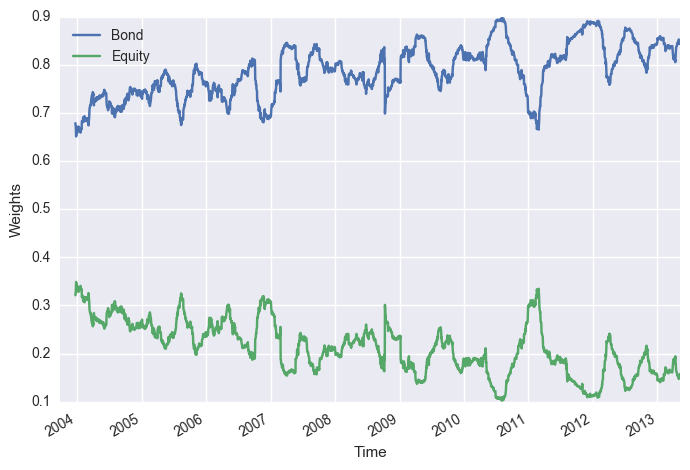

In [6]:
print("Sharpe ratio of each individual asset")
display(pt_ret.mean()/pt_ret.std()*np.sqrt(252))

print("Sharpe ratio of equally weighted portfolio")
display(df_ret_static.mean()/df_ret_static.std()*np.sqrt(252))

print("Sharpe ratio of Risk Parity portfolio ")
display(df_ret_rp.mean()/df_ret_rp.std()*np.sqrt(252))

ax = wts.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Weights")
#On average 67% is allocated to bonds, 16% to gold and 18% to equities
wts.mean()



# Multiple Asset RP containing highly correlated assets 

,AGG,EEM,GLD,IWM,QQQ,SPY,TLT
AGG,1.00,-0.12,0.08,-0.18,-0.13,-0.10,0.54
EEM,-0.12,1.00,0.19,0.82,0.84,0.89,-0.40
GLD,0.08,0.19,1.00,0.07,0.04,0.07,0.04
IWM,-0.18,0.82,0.07,1.00,0.88,0.92,-0.44
QQQ,-0.13,0.84,0.04,0.88,1.00,0.91,-0.42
SPY,-0.10,0.89,0.07,0.92,0.91,1.00,-0.45
TLT,0.54,-0.40,0.04,-0.44,-0.42,-0.45,1.00


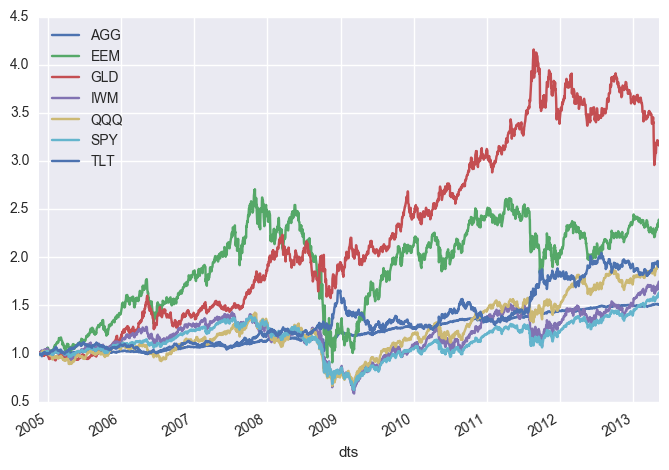

In [7]:
cols = ["dts","AGG","TLT","GLD","SPY","QQQ","IWM","EEM"]
df = pd.read_csv(file_etfs,usecols= cols, index_col='dts')
df.set_index(pd.to_datetime(df.index,format="%Y%m%d"),inplace=True)
df = df.dropna(0)
df_ret = df.pct_change()
display(np.round(df_ret.corr(),2))

ax = (1+df_ret).cumprod().plot()



# Real Risk Parity 

In [8]:
#risk parity considering correlation
cov_df = df_ret[["AGG", "GLD", "SPY"]].cov()

def wgt_wrapper(wgt, cov):
    
    a = wgt[0]**2 * cov.iloc[0, 0] + \
        wgt[0]*wgt[1] * cov.iloc[1,0] + \
        wgt[0]*(1 - wgt[0] - wgt[1]) * cov.iloc[2,0]
        
    b = wgt[0]*wgt[1] * cov.iloc[0,1] + \
        wgt[1]**2 * cov.iloc[1,1] + \
        wgt[1]*(1 - wgt[0] - wgt[1]) * cov.iloc[2,1]
        
    c = wgt[0]*(1 - wgt[0] - wgt[1]) * cov.iloc[0,2] + \
        wgt[1]*(1 - wgt[0] - wgt[1]) * cov.iloc[1,2] + \
        (1 - wgt[0] - wgt[1])**2 * cov.iloc[2,2]
    
    
    return abs(a - b)+ abs(b - c) + abs(a - c)

def cal_wgt(cov_df):
    ans = minimize(wgt_wrapper, [0.0, 0.0], (cov_df), bounds=((0,1), (0,1)))
    return ans.x

#exponential weighted average covaraince
cov_dict = df_ret.ewm(halflife=120).cov() * np.sqrt(252)




In [9]:
cov_dict = df_ret[["AGG", "GLD", "SPY"]].ewm(halflife =240).cov() 

AGG_ls = []
GLS_ls = []
SPY_ls = []


for cov_arr in cov_dict.values:
    
    if ~np.isnan(cov_arr[0,0]):
        cov_df = pd.DataFrame(cov_arr* np.sqrt(252))
        wgt_arr = cal_wgt(cov_df)
        if (1 - wgt_arr[0] - wgt_arr[1]) <= 0:
            AGG_ls.append(AGG_ls[-1])
            GLS_ls.append(GLS_ls[-1])
            SPY_ls.append(SPY_ls[-1])
        else:
            AGG_ls.append(wgt_arr[0])
            GLS_ls.append(wgt_arr[1])
            SPY_ls.append(1 - wgt_arr[0] - wgt_arr[1])

wgt_df = pd.DataFrame({"AGG": AGG_ls, \
                       "GLD": GLS_ls, \
                       "SPY": SPY_ls})
    
wgt_df.mean()


AGG    0.663679
GLD    0.153716
SPY    0.182605
dtype: float64

## RRP weight

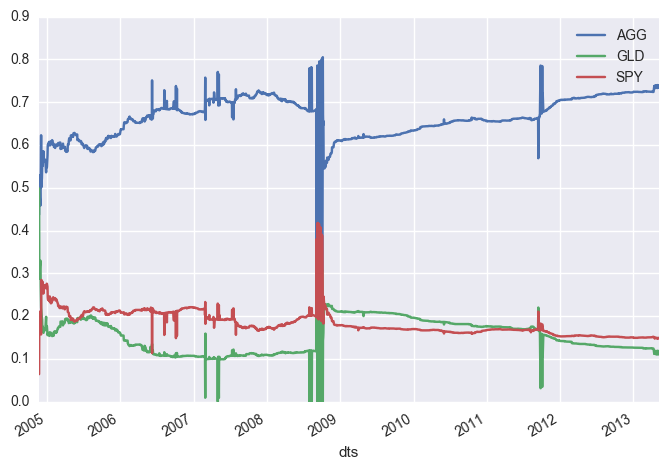

In [10]:
wgt_df.index = df_ret.index[2:]

wgt_df.plot()

In [11]:
df_ret[["AGG", "GLD", "SPY"]].corr()

,AGG,GLD,SPY
AGG,1.000000,0.078391,-0.104407
GLD,0.078391,1.000000,0.073340
SPY,-0.104407,0.073340,1.000000


In [12]:
import datetime as dt
start = dt.datetime(2008, 2, 1)
end = dt.datetime(2010, 1, 1)
crsis_df = df_ret[["AGG", "GLD", "SPY"]][(df_ret.index > start) &  (df_ret.index < end)]
crsis_df.corr()

,AGG,GLD,SPY
AGG,1.000000,0.099387,-0.000243
GLD,0.099387,1.000000,0.011874
SPY,-0.000243,0.011874,1.000000


In [43]:
cov_dict.values[1200]


array([[  3.07885374e-05,   7.55959052e-06,  -1.72634363e-06],
       [  7.55959052e-06,   2.62614036e-04,   1.16049595e-05],
       [ -1.72634363e-06,   1.16049595e-05,   4.25732725e-04]])